# Downloads e Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

from scipy.stats import kruskal

from xgboost import XGBRegressor
import multiprocessing


#### Função para mostrar resultados do modelo

In [2]:
def getResults(x_test, y_test, model,round_results = False, range_results = None):
    predicted = model.predict(x_test)
    
    if range_results:
        lowest_label,highest_label = range_results
        if lowest_label:
            predicted[predicted < lowest_label] = lowest_label
        if highest_label:
            predicted[predicted > highest_label] = highest_label

    if round_results: predicted = np.round(predicted)


    cm = confusion_matrix(y_test, predicted)
    sns.heatmap(cm, center=True)
    plt.show()
    report = classification_report(y_test, predicted)
    print(report)
     

## Download dataset

In [3]:
X = np.load("/content/Fourier_X.npy")
y = np.load("/content/y_aprox.npy")

print(np.unique(y,return_counts=True))

(array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype='<U10'), array([1629, 4922, 1232,  988, 2108, 8637]))


Como a diferenca entre as quantidades de samples de cada classe é inferior a 10 vezes, então não rebalancearei, mas isso pode ser importante dependendo do classificador e seria conveniente balancear

In [4]:
counter = 0
for x in X:
    if np.isnan(x).sum(): counter += 1
print("n entradas com nan:",counter)

n entradas com nan: 124


In [5]:
indices = []
for index,x in enumerate(X):
    if np.isnan(x).sum() == 0:
        indices.append(index)

X = X[indices]
y = y[indices]

In [6]:
counter = 0
for x in X:
    if np.isnan(x).sum(): counter += 1
print("n entradas com nan:",counter)

n entradas com nan: 0


In [7]:
X = (X - X.min())/(X.max() - X.min())

# random seed setting

In [8]:
RANDSEED = 1234

os.environ['PYTHONHASHSEED']=str(RANDSEED)
np.random.seed(RANDSEED)

#train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDSEED)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDSEED)

# training

In [10]:
np.isnan(np.array([np.NaN,np.NaN,1,2,3])).sum()

2

### Random forest

In [11]:
# fazendo gridseearch para procurar melhor modelo
rfc = RandomForestClassifier(n_jobs=multiprocessing.cpu_count() // 2)

search_space ={ 'max_depth': [2, 4, 6, 10],
        'n_estimators': [10, 25, 50],
        'criterion'          : ['gini', 'entropy'],
        'min_samples_split'  : [5,7]
}
clf_rfc = GridSearchCV(rfc, search_space, verbose=1,
                    n_jobs=2)
clf_rfc.fit(X_train, y_train)
print(clf_rfc.best_score_)
print(clf_rfc.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.8081484653776503
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


In [12]:
rfc = RandomForestClassifier(criterion= 'entropy', max_depth = 10, min_samples_split=  5, n_estimators = 50)
rfc.fit(X_train,y_train)
print(rfc.score(X_val,y_val))

0.8087135859757669


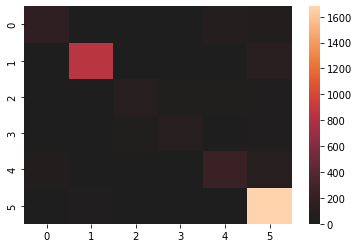

              precision    recall  f1-score   support

  Downstairs       0.62      0.54      0.58       327
     Jogging       0.94      0.87      0.91       976
     Sitting       0.67      0.43      0.53       240
    Standing       0.63      0.51      0.57       191
    Upstairs       0.61      0.57      0.59       398
     Walking       0.84      0.96      0.90      1747

    accuracy                           0.81      3879
   macro avg       0.72      0.65      0.68      3879
weighted avg       0.80      0.81      0.80      3879



In [13]:
getResults(X_val,y_val,rfc)

### XGboost

In [14]:
label_converter = {
'Downstairs' : 0, 
 'Jogging': 1, 
 'Sitting': 2, 
 'Standing': 3,
 'Upstairs': 4,
'Walking': 5 }

label_deconverter = {
 0  :'Downstairs'  , 
 1  : 'Jogging'    , 
 2  : 'Sitting'    ,  
 3  : 'Standing'   ,
 4  : 'Upstairs'   ,
 5  :'Walking'      }

y_train_numerical =np.array( [label_converter[label_name] for label_name in y_train])
y_val_numerical = np.array( [label_converter[label_name] for label_name in y_val])
y_test_numerical = np.array( [label_converter[label_name] for label_name in y_test])

print(np.unique(y_train_numerical, return_counts = True))
print(np.unique(y_val_numerical, return_counts = True))
print(np.unique(y_test_numerical, return_counts = True))

(array([0, 1, 2, 3, 4, 5]), array([1003, 2908,  735,  602, 1271, 5115]))
(array([0, 1, 2, 3, 4, 5]), array([ 327,  976,  240,  191,  398, 1747]))
(array([0, 1, 2, 3, 4, 5]), array([ 299,  976,  257,  195,  439, 1713]))


In [15]:
print(y_train[:10])
print(y_train_numerical[:10])

['Downstairs' 'Jogging' 'Walking' 'Downstairs' 'Walking' 'Walking'
 'Standing' 'Walking' 'Walking' 'Downstairs']
[0 1 5 0 5 5 3 5 5 0]


In [16]:
clf_xgb = GridSearchCV(XGBRegressor(), {'max_depth': [2, 4, 6,10],
                                'n_estimators': [10,25, 50]}, verbose=1,
                    n_jobs=2)
clf_xgb.fit(X_train, y_train_numerical)
print(clf_xgb.best_score_)
print(clf_xgb.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.5931163427464048
{'max_depth': 6, 'n_estimators': 25}


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.], dtype=float32), array([   3,   87,  700,  529,  712,  712, 1135,    1]))
(array([0., 1., 2., 3., 4., 5.], dtype=float32), array([  90,  700,  529,  712,  712, 1136]))


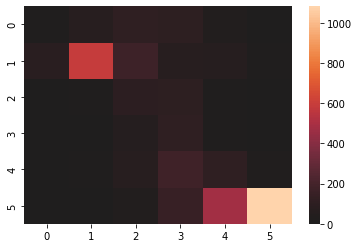

              precision    recall  f1-score   support

  Downstairs       0.14      0.04      0.06       327
     Jogging       0.84      0.60      0.70       976
     Sitting       0.18      0.39      0.24       240
    Standing       0.16      0.59      0.25       191
    Upstairs       0.16      0.28      0.20       398
     Walking       0.95      0.62      0.75      1747

    accuracy                           0.52      3879
   macro avg       0.40      0.42      0.37      3879
weighted avg       0.69      0.52      0.57      3879



In [17]:
# best xgb of the gridsearch
xgb = XGBRegressor(max_depth = 6, n_estimators= 25)
xgb.fit(X_train,y_train_numerical)

predicted = xgb.predict(X_val)
predicted = np.round(predicted)

predicted[predicted > 5] = 5
predicted[predicted< 0] = 0

predicted = np.array( [label_deconverter[label_name] for label_name in predicted])


cm = confusion_matrix(y_val, predicted)
sns.heatmap(cm, center=True)
plt.show()
report = classification_report(y_val, predicted)
print(report)
    